# Portfolio return, risk and optimization

In this notebook we will take an example portfolio, calculate its return, risk and lastly we will optimize it.

In [2]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import pprint

pd.set_option("display.max_rows", 4)
pd.set_option("display.max_columns", 30)

# What is portfolio optimization?

When making a portfolio, a part (weight) of the capital must be allocated to each asset. Depending on the assets and their weights, the portfolio will have a certain amount of risk and an expected return.

Portfolio optimization consists in finding weights combinations such that:

a) For a target return, risk is minimized

or

b) For a target risk, return is maximized

## 0. Set-up

The portfolio will consist of the following assets, and it will be analyzed using the assets' daily historical data going back 5 years.

In [3]:
assets = [                 
                "XOM", # energy
                "SHW", # materials
                "UPS", # industrial
                "ED", # utilities
                "JNJ", # healthcare
                "JPM", # financial sector
                "MCD", # consumer discretionary
                "PG", # # consumer staples
                "MSFT", # information technology
                "GOOG", # communications services
                "SPG" # real state
            ]
n = len(assets) # quantity of assets in the portfolio
period = "5y" #5 years worth of data
interval = "1d" # data from every day

## 1. Assets analysis

### 1.1. Assets' historical prices

In [4]:
def get_historical_prices():
    '''
    Retrieves assets' historical Adjusted-Close prices using yfinance
     
    Returns:
    + historical_prices: pandas dataframe
        Historical price data. One column per asset
    '''
    
    request = " ".join(assets)
    historical_prices = yf.download(request, period=period, interval=interval)["Adj Close"]
    
    # yfinance queries in alphabetical order
    # re-order columns according to 'tickers' order
    historical_prices = historical_prices[assets]
    
    return historical_prices

In [5]:
historical_prices = get_historical_prices()
historical_prices

[*********************100%***********************]  11 of 11 completed


,XOM,SHW,UPS,ED,JNJ,JPM,MCD,PG,MSFT,GOOG,SPG
Date,,,,,,,,,,,
2018-06-04,62.503979,123.284935,100.154175,62.355927,106.750229,93.356148,142.572098,65.018288,96.159248,56.964500,125.320229
2018-06-05,62.280125,124.425850,100.017174,61.573898,106.338806,92.831039,141.913574,64.834244,96.651077,56.983002,125.559113
...,...,...,...,...,...,...,...,...,...,...,...
2023-06-01,103.360001,234.889999,167.830002,91.820000,154.539993,137.580002,286.350006,143.960007,332.579987,124.370003,103.400002
2023-06-02,105.760002,240.830002,170.139999,91.760002,156.970001,140.470001,289.910004,146.520004,335.399994,125.230003,106.510002


### 1.2. Assets' historical returns

Asset returns:

$$
r_{j} = \frac {P_{t+1}-P_t}{P_t}\ = \frac {P_{t+1}}{P_t}\ - 1
$$

Where:
- r<sub>j</sub>: Return on asset j
- P<sub>t</sub>: Price of j at time t
- P<sub>t+1</sub>: Price of j at time t+1

In [6]:
def get_historical_returns(historical_prices):
    '''
    Calculates historical normal returns. Time delta = 1
    
    Parameters:
    + historical_prices: dataframe
        historical price data 
    
    Returns:
    + returns_data: dataframe
        daily returns of each asset
    '''
    historical_returns = pd.DataFrame()
    
    for asset in assets:
        historical_returns[asset] = historical_prices[asset] / historical_prices[asset].shift(1) - 1
    
    historical_returns = historical_returns.iloc[1:, :] # drop first row because it doesn't contain info
    
    return historical_returns

In [7]:
historical_returns = get_historical_returns(historical_prices)
historical_returns

,XOM,SHW,UPS,ED,JNJ,JPM,MCD,PG,MSFT,GOOG,SPG
Date,,,,,,,,,,,
2018-06-05,-0.003581,0.009254,-0.001368,-0.012541,-0.003854,-0.005625,-0.004619,-0.002831,0.005115,0.000325,0.001906
2018-06-06,0.017105,0.013165,0.001798,-0.021889,0.010784,0.023368,0.018184,0.005137,0.002936,-0.002439,0.014362
...,...,...,...,...,...,...,...,...,...,...,...
2023-06-01,0.011548,0.031214,0.004970,-0.015863,-0.003354,0.013779,0.009681,0.010246,0.012759,0.008106,-0.016643
2023-06-02,0.023220,0.025288,0.013764,-0.000653,0.015724,0.021006,0.012432,0.017783,0.008479,0.006915,0.030077


### 1.3. Assets' expected returns

Each asset's expected return can be obtained as the mean of each asset's historical returns

In [8]:
assets_expected_returns = historical_returns.mean() # daily
assets_expected_returns = (assets_expected_returns + 1)**250 - 1 # yearly
assets_expected_returns *= 100 # percentage
assets_expected_returns 

XOM     17.625011
SHW     19.579658
          ...    
GOOG    22.978432
SPG      8.472922
Length: 11, dtype: float64

### 1.4. Assets' historical returns' variance-covariance matrix

In [9]:
variance_covariance_matrix = historical_returns.cov()
variance_covariance_matrix *= 250 # yearly
correlation_matrix = historical_returns.corr()

variance_covariance_matrix

,XOM,SHW,UPS,ED,JNJ,JPM,MCD,PG,MSFT,GOOG,SPG
XOM,0.115761,0.029292,0.035553,0.020107,0.022233,0.065192,0.031054,0.017784,0.033367,0.036708,0.083959
SHW,0.029292,0.091038,0.040911,0.025200,0.024494,0.042378,0.037595,0.029569,0.047473,0.043737,0.055789
...,...,...,...,...,...,...,...,...,...,...,...
GOOG,0.036708,0.043737,0.042523,0.016119,0.023096,0.046635,0.031922,0.025170,0.077279,0.100744,0.051609
SPG,0.083959,0.055789,0.041259,0.024066,0.022119,0.092858,0.054170,0.020367,0.047480,0.051609,0.225697


## 2. Portfolio 0: Un-optimized weights

### 2.1. Initial weights ##
The initial weights can be assigned randomly, evenly or subjectively on each asset of the portfolio

In [10]:
def get_even_weights():
    ''' 
    Creates even weights for each asset. Weights add-up to 1 (100%)
        
    Returns:
    + weights: numpy array
        n random weights that add up to 1
    '''
    weights = n * [1 / n] # n even weights that add-up to 1
    weights = np.round(weights, 4)
    return weights    

In [11]:
def get_random_weights():
    ''' 
    Creates random positive weights for each asset. Weights add-up to 1 (100%)
        
    Returns:
    + weights: numpy array
        n random weights that add up to 1
    '''
    weights = np.random.random_sample(size = n) # sum != 1
    weights = np.round(weights, 4)
    weights = weights / weights.sum() # sum = 1
   
    return weights

### 2.2. Portfolio expected return

The Expected Return of a portfolio is can be calculated with the sum of the products of each assets' weight and expected return.

$$
r_p = \sum_{i=1}^k \omega_i r_i
$$

Where:
- w<sub>j</sub>: Weight of asset i
- r<sub>t</sub>: Expected return of asset i

In [12]:
def get_portfolio_return(weights):
    '''
    Calculates a portfolio's expected return for the given asset's weights.
    
    Parameters:
    + weights: numpy array
        assets' weights
        
    Returns:
    + portfolio_return: float
        The portfolio's expected return
    '''
    portfolio_return = (weights * assets_expected_returns).sum()
    return portfolio_return 

### 2.3. Portfolio risk

Portfolio variance:

$$
\sigma_p^2 = \sum_{i=1}^{n}
                \sum_{j=1}^{n}
                w_i w_j Cov(r_i, r_j)
$$

Where:
- n: number of assets
- i, j: assets i and j
- w<sub>i</sub>: weight of asset i
- Cov(r<sub>i</sub>, r<sub>j</sub>): Covariance between Expected returns of assets i and j

Or:

$$
\sigma_p^2 =w' V w
$$

- w: weights matrix
- V: variance-covariance matrix

Portfolio risk (standard deviation):

$$
\sigma_p = \sqrt{\sigma_p^2}
$$

In [13]:
def get_portfolio_risk(weights):
    '''
    Calculates portfolio variance and then risk (standard deviation).
    
    Parameters:
    + weights: numpy array
        assets' weights
    
    Returns:
    + portfolio_risk: float
    '''
    w = weights
    v = variance_covariance_matrix.values # .values allows for matrix operations
    
    portfolio_variance = (w.dot(v)).dot(w)
    '''
    portfolio_variance = 0
    for i in range(n):
        for j in range(n):
            ticker_i = tickers[i]
            ticker_j = tickers[j]
            portfolio_variance += weights[i] * weights[j] * variance_covariance_matrix[ticker_i][ticker_j]
    '''
    portfolio_risk = portfolio_variance ** 0.5 # standard deviation
    portfolio_risk = portfolio_risk * 100 # percentage
    #portfolio_risk *= 250 ** 0.5 # yearly

    return portfolio_risk

In [14]:
def make_portfolio(weights):
    '''
    Creates a portfolio
    
    Parameters:
    + weights: np.array
        weights of each asset
        
    Returns:
    + portfolio: dictionary
        contains weights, risk and return
    '''
    weights = np.array(weights)
    portfolio_return = get_portfolio_return(weights)
    risk = get_portfolio_risk(weights)
    
    portfolio = {
        'weights': weights,
        'risk': risk,
        'return': portfolio_return
    }
    
    return portfolio

In [15]:
def make_random_portfolio():
    weights = get_random_weights()
    portfolio_return = get_portfolio_return(weights)
    portfolio_risk = get_portfolio_risk(weights)
    
    portfolio = {
        'weights': weights,
        'return': portfolio_return,
        'risk': portfolio_risk
    }
    
    return portfolio

In [16]:
def print_portfolio(portfolio):
    '''
    Small helper function
    
    Parameters:
    + portfolio: portfolio dictionary
    
    Returns:
    prints portfolio's risk, return and shows each asset with their weights
    '''
    weights = portfolio['weights']
    risk = portfolio['risk']
    ret = portfolio['return']
    print(f'Risk:\t{risk}')
    print(f'Return:\t{ret}')
    df = pd.DataFrame(data=weights, index=assets, columns=['Weight'])
    return df.transpose()

In [17]:
portfolio_0 = make_portfolio(get_even_weights())
print('Portfolio 0')
print_portfolio(portfolio_0)

Portfolio 0
Risk:	20.208841285315064
Return:	17.59821955913452


,XOM,SHW,UPS,ED,JNJ,JPM,MCD,PG,MSFT,GOOG,SPG
Weight,0.0909,0.0909,0.0909,0.0909,0.0909,0.0909,0.0909,0.0909,0.0909,0.0909,0.0909


## 2. Portfolio 1: Risk-optimized Portfolio 0

It is possible to optimize a portfolio's assets' weights such that its **return stays the same, but its risk is minimized**. This portfolio will exist in the Efficient frontier.

### 2.1. Risk-optimized weights

Weights that maintain an expected return but minimize risk

$$
\begin{split}
w_{(nx1)} =
\bigr[V^{-1}\bigr]_{(n\times n)}
&&
\bigl(\mu, \mathbf{1}\bigl)_{(n\times 2)}
&&
\biggl\{
    \bigl(
        \mu, \mathbf{1}
    \bigl)^{\mathbf{'}}_{(2\times n)}
    &&
    V^{-1}_{(n\times n)}
    &&
    \bigl(
        \mu, \mathbf{1}
    \bigl)_{(n\times 2)}
\biggl\}^{-1}_{(2\times 2)}
&&
\begin{bmatrix}
E(R_{p}) \\
1
\end{bmatrix}_{(2x1)}
\end{split}
$$

Where:
- V: Variance-covariance matrix of the assets

$$
\begin{split}
    \mu=
    &&
    \begin{bmatrix}
        \mu_1 \\
        \vdots \\
        \mu_n
    \end{bmatrix}
    &&
    =
    &&
    \begin{bmatrix}
        E(R_1) \\
        \vdots \\
        E(R_n)
    \end{bmatrix}
\end{split}
$$

$$
\begin{split}
    \begin{pmatrix}
        \mu, \mathbf{1}
    \end{pmatrix}
    &&
    =
    &&
    \begin{bmatrix}
        \mu_1 & 1 \\
        \vdots & \vdots \\
        \mu_n & 1
    \end{bmatrix}
\end{split}
$$

In [18]:
def get_risk_optimized_weights(portfolio_expected_return):
    '''
    Calculates risk-minimizing weights for a target portfolio return
    
    Parameters:
    + portfolio_expected_return: float
        expected return of the portfolio
    
    Returns:
    + optimized_weights: np.array
        weights that minimize risk but maintain the target return
    '''
    v = variance_covariance_matrix
    v_inv = np.linalg.inv(v)
    
    mu = assets_expected_returns.values
    mu_1 = np.c_[mu ,np.ones(n)]

    two_two = np.dot(np.dot(mu_1.T, v_inv), mu_1)
    two_two_inv = np.linalg.inv(two_two)

    two_one = np.array([portfolio_expected_return, 1])

    optimized_weights = np.dot(v_inv, mu_1)
    optimized_weights = np.dot(optimized_weights, two_two_inv)
    optimized_weights = np.dot(optimized_weights, two_one)
    
    return optimized_weights

Using the formula above, we obtain Portfolio 1's weights

In [19]:
get_risk_optimized_weights(portfolio_0['return'])

array([ 0.11323905,  0.00848227,  0.06303028,  0.09693489,  0.23929349,
       -0.07846982,  0.25170524,  0.25172782,  0.03725115,  0.05791928,
       -0.04111365])

We can verify that the returns are the same

In [20]:
weights_1 = get_risk_optimized_weights(portfolio_0['return'])
portfolio_0['return'] - get_portfolio_return(weights_1)

3.552713678800501e-15

### 2.2. Calculate new risk

In [21]:
risk_1 = get_portfolio_risk(weights_1)
risk_1

17.30720121556638

In [22]:
def risk_optimize_portfolio(portfolio):
    '''
    Minimizes a portfolio's risk but keep its return
    
    Parameters:
    + portfolio: dictionary
        portfolio to risk-optimize
    
    Returns:
    + portfolio: dictionary
        A portfolio with weights that minimize risk but maintain the original
        portfolio's return
    '''
    portfolio = portfolio.copy()
    
    portfolio_return = portfolio['return']
    
    weights = get_risk_optimized_weights(portfolio_return)
    risk = get_portfolio_risk(weights)
    
    portfolio['weights'] =  weights
    portfolio['risk'] = risk
    
    return portfolio

In [23]:
def make_frontier_portfolio():
    '''
    Makes a random portfolio an then
    brings it to the Efficient Frontier
    
    Parameters:
    None
    
    Returns:
    + portfolio: dictionary
        A portfolio that lies in a random point
        in the efficient frontier
    '''
    portfolio = make_random_portfolio()
    portfolio = risk_optimize_portfolio(portfolio)
    
    return portfolio

In [24]:
portfolio_1 = risk_optimize_portfolio(portfolio_0)
print('Portfolio 1')
print_portfolio(portfolio_1)

Portfolio 1
Risk:	17.30720121556638
Return:	17.59821955913452


,XOM,SHW,UPS,ED,JNJ,JPM,MCD,PG,MSFT,GOOG,SPG
Weight,0.113239,0.008482,0.06303,0.096935,0.239293,-0.07847,0.251705,0.251728,0.037251,0.057919,-0.041114


Text(0.5, 0, 'Risk (%)')

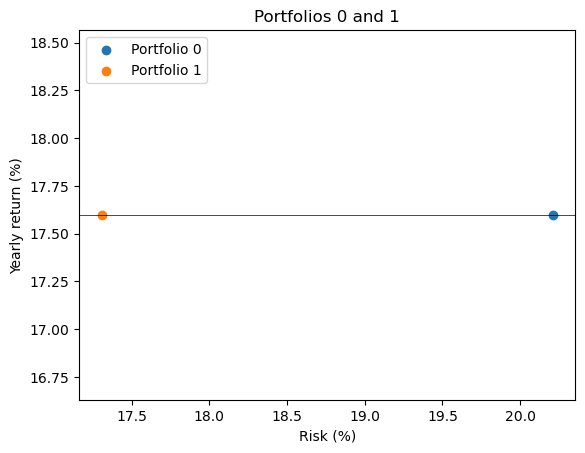

In [25]:
# Portfolios
plt.scatter(portfolio_0['risk'], portfolio_0['return'])
plt.scatter(portfolio_1['risk'], portfolio_1['return'])

# Details
plt.legend(["Portfolio 0" , "Portfolio 1"], loc = "upper left")
plt.axhline(portfolio_0['return'], color='black', linewidth=.5)

plt.title('Portfolios 0 and 1')
plt.ylabel('Yearly return (%)')
plt.xlabel('Risk (%)')

## 3. Portfolio 2: Global minimum-risk

It is also possible to directly find the portfolio with the lowest possible variance/risk.

Minimum-variance-portfolio return:

$$
\begin{split}
    \mu_* = 
    \frac {\mathbf{1^{'}}V^{-1}\mu}
          {\mathbf{1^{'}}V^{-1}\mathbf 1}
\end{split}
$$

Global minimum-variance:

$$
\begin{split}
    \sigma^2_* = 
    (\mathbf{1^{'}}V^{-1}\mathbf 1)^{-1}
\end{split}
$$

Minimum-variance-portfolio weights:

$$
\begin{split}
    w_* = 
    \frac {V^{-1}{\mathbf 1}}
          {\mathbf{1^{'}}V^{-1}\mathbf 1}
\end{split}
$$

Where:
- &mu;: Expected returns vector
- V: Historic returns variance-covariance matrix

In [26]:
def get_minimum_variance_return():
    '''
    Directly calculates the portfolio return of
    the minimum-variance portfolio.
    This is purely assets' dependent.
        
    Returns:
    + minimum_variance_return: float
        Portfolio return of the minimum-variance portfolio
    '''
    
    ones_vector = np.array(np.ones(n))
    v = variance_covariance_matrix
    v_inv = np.linalg.inv(v)
    mu = assets_expected_returns
    
    numerator = np.dot(np.dot(ones_vector, v_inv), mu)
    denominator = np.dot(np.dot(ones_vector, v_inv), ones_vector)

    minimum_variance_return = numerator / denominator
    
    return minimum_variance_return

In [27]:
def get_global_minimum_variance():
    '''
    Directly calculates the minimum variance possible
    This is purely assets' dependent.
    
    Returns:
    + global_minimum_variance: float
        The minimum variance possible
    '''
    ones_vector = np.array(np.ones(n))
    v = variance_covariance_matrix
    v_inv = np.linalg.inv(v)
    
    global_minimum_variance = np.dot(np.dot(ones_vector, v_inv), ones_vector)
    #global_minimum_variance = np.linalg.inv(global_minimum_variance)
    global_minimum_variance = 1 / global_minimum_variance
    
    return global_minimum_variance

In [28]:
def get_minimum_variance_weights():
    '''
    Directly calculates the weights that yield the
    least variance
    This is purely assets-dependent
    
    Returns:
    + min_variance_weights: np.array
        Weights for each asset that yield the
        lowest possible variance
    '''
    ones_vector = np.array(np.ones(n))
    v = variance_covariance_matrix
    v_inv = np.linalg.inv(v)
    
    numerator = np.dot(v_inv, ones_vector)
    denominator = np.dot(np.dot(ones_vector.T, v_inv), ones_vector)
    
    min_variance_weights = numerator / denominator

    return min_variance_weights

In [29]:
def make_global_min_variance_portfolio():
    '''
    Finds the portfolio with the minimum variance and returns it
    
    Returns:
    + portfolio: dictionary
        The portfolio with the least-possible variance
    '''
    
    portfolio = make_random_portfolio()
    portfolio['weights'] = get_minimum_variance_weights()
    portfolio['risk'] = get_global_minimum_variance() ** 0.5 * 100
    portfolio['return'] = get_minimum_variance_return()
    
    return portfolio

In [30]:
portfolio_2 = make_global_min_variance_portfolio()
print('Portfolio 2')
print_portfolio(portfolio_2)

Portfolio 2
Risk:	17.00250889463263
Return:	14.182723190490073


,XOM,SHW,UPS,ED,JNJ,JPM,MCD,PG,MSFT,GOOG,SPG
Weight,0.085031,0.004761,0.083619,0.135547,0.339644,-0.063035,0.240379,0.179252,-0.095358,0.111214,-0.021054


Text(0.5, 0, 'Risk (%)')

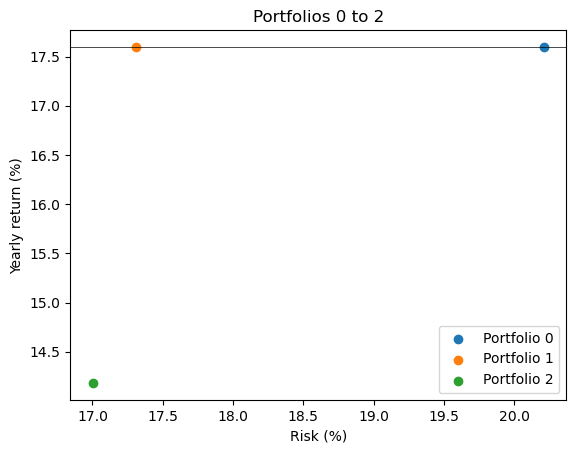

In [31]:
plt.scatter(portfolio_0['risk'], portfolio_0['return'])
plt.scatter(portfolio_1['risk'], portfolio_1['return'])
plt.scatter(portfolio_2['risk'], portfolio_2['return'])

plt.legend(["Portfolio 0" , "Portfolio 1", "Portfolio 2"], loc = "lower right")

plt.axhline(portfolio_0['return'], color='black', linewidth=.5)

plt.title('Portfolios 0 to 2')
plt.ylabel('Yearly return (%)')
plt.xlabel('Risk (%)')

## 4. Efficient Frontier as combinations of Portfolios 1 and 2

###  4.1.  Efficient Frontier

The efficient frontier can be drawn by linearly combining portfolios 1 and 2 and ploting those combinations

In [32]:
def combine_portfolios_2(portfolio_1, portfolio_2, low_proportion, high_proportion, steps):
    '''
    Linearly combines 2 portfolio's weights
    
    Parameters:
    + portfolio_1: dictionary
        One of the portfolios to combine
        
    + portfolio_2: dictionary
        One of the portfolios to combine
        
    + low_proportion: number
        Least amount by which portfolio_1's weights will be scaled.
        
        >0: combinations with risks higher than portfolio_1's 
         0: combinations' risks will start from portfolio_1's
        <0: combinations with risks lower than portfolio_1's
        
    + high_proportion: number
        Maximum amount by which portfolio_2's weights will be scaled.
        
        >1: combinations with risks higher than portfolio_2's
         1: combinations' risks will end at portfolio_2's
        <1: combinations's risks will end lower than portfolio_2's
    
    Returns:
    + combinations_weights: list
        list of the combinations's weights
    
    + combinations_risks: list
        list of the combinations' risks
    
    + combinations_returns: list
        list of the combinations' returns
    '''
    combinations_weights = []
    combinations_risks = []
    combinations_returns = []
    
    proportions = np.arange(low_proportion, high_proportion, steps)
    for i in proportions:
        proportion_1 = i
        proportion_2 = 1 - i
        
        combo_weights = portfolio_1['weights'] * proportion_1 + portfolio_2['weights'] * proportion_2
        combo_risk = get_portfolio_risk(combo_weights)
        combo_return = get_portfolio_return(combo_weights)
        
        combinations_weights.append(combo_weights)
        combinations_risks.append(combo_risk)
        combinations_returns.append(combo_return)
    
    return combinations_weights, combinations_risks, combinations_returns

In [33]:
combos_weights, combos_risks, combos_returns = combine_portfolios_2(portfolio_1, portfolio_2, -4, 4, 0.01)

Text(0.5, 0, 'Risk (%)')

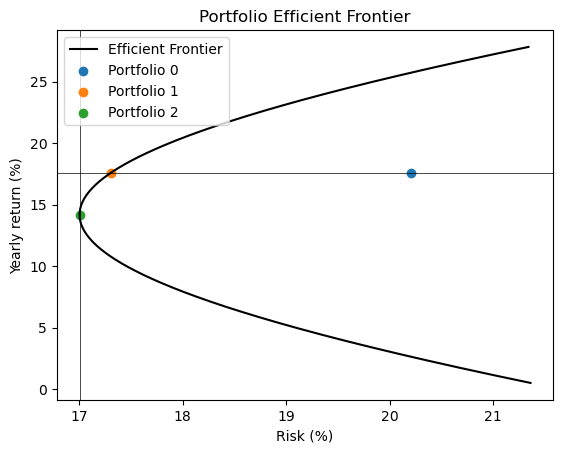

In [34]:
plt.plot(combos_risks, combos_returns, 'black')

plt.scatter(portfolio_0['risk'], portfolio_0['return'])
plt.scatter(portfolio_1['risk'], portfolio_1['return'])
plt.scatter(portfolio_2['risk'], portfolio_2['return'])

plt.legend(["Efficient Frontier", "Portfolio 0" , "Portfolio 1", "Portfolio 2"], loc = "upper left")
plt.axhline(portfolio_0['return'], color='black', linewidth=.5)
plt.axvline(portfolio_2['risk'], color='black', linewidth=.5)

plt.title('Portfolio Efficient Frontier')
plt.ylabel('Yearly return (%)')
plt.xlabel('Risk (%)')

The Efficient Frontier shows the maximum and minimum returns for any given risk. For investment purposes, only the upper half is relevant, as investors are interested in maximizing their returns, rather than minimizing them.

### 4.2. Portfolio 3: Return-optimized weights for Portfolio 0

Knowing 2 portfolios that lie on the Efficient Frontier, it is possible to formulate a combination of them such that while maintaining the risk, the return is optimized.

$$
P_1 w_1 + P_2 w_2 = P_3
$$
$$
w_1 + w_2 = 1
$$

For a 2-asset portfolio, the variance is calculated as:

$$
\begin{split}
\sigma^2_{p} = 
    w^2_1\sigma^2_1
    + w^2_2\sigma^2_2
    + 2 w_1 w_2 \sigma_{1, 2}
\end{split}
$$

Plugging in:

$$
w_2 = 1 - w_1
$$

After expanding and factorizing w<sub>1</sub>:

$$
0 = w^2_1(\sigma^2_1 + \sigma^2_2 - 2\sigma_{1,2}) + w_1(2\sigma_{1,2} - 2\sigma^2_2) + (\sigma^2_2 - \sigma^2_p)
$$

Plugging in all the values and solving for w<sub>1</sub> will return 2 values. We choose the one that generates a portfolio with greater return.

In [35]:
def return_optimize_portfolio(portfolio_0, frontier_portfolio_1, frontier_portfolio_2):
    '''
    Finds a portfolio that keeps a base portfolio's risk but with maximum return
    
    Parameters:
    + portfolio_0: dictionary
        Un-optimazided portfolio to vertically project on the Efficient Frontier
    
    + frontier_portfolio_1: dictionary
        A known portfolio that lies in the Efficient Frontier
        
    + frontier_portfolio_2: dictionary
        A known portfolio that lies in the Efficient Frontier

    Returns:
    A portfolio with with portfolio_0's risk but maximized returns
    '''
    
    v = variance_covariance_matrix
    
    risk_0 = portfolio_0['risk']
    var_0 = (portfolio_0['risk'] / 100) ** 2 # remove %
    
    weights_1 = frontier_portfolio_1['weights']
    weights_2 = frontier_portfolio_2['weights']
    
    var_1 = (frontier_portfolio_1['risk'] / 100) ** 2 # remove %
    var_2 = (frontier_portfolio_2['risk'] / 100) ** 2 # remove %
    cov_1_2 = np.dot(np.dot(weights_1, v), weights_2)
    
    # coefficients of the quadratic ecuation
    a = var_1 + var_2 - 2 * cov_1_2
    b = 2 * cov_1_2 - 2 * var_2
    c = var_2 - var_0
    
    # solving the cuadratic ecuation
    positive_root = -b + (b**2 - 4 * a * c)**0.5
    positive_root = positive_root / (2 * a)
    positive_root_weights = weights_1 * (positive_root) + weights_2 * (1 - positive_root)
    
    negative_root = -b - (b**2 - 4 * a * c)**0.5
    negative_root = negative_root / (2 * a)
    negative_root_weights = weights_1 * (negative_root) + weights_2 * (1 - negative_root)
    
    # choosing which root is adecuate
    if get_portfolio_return(positive_root_weights) > portfolio_0['return']:
        return make_portfolio(positive_root_weights)
    else:
        return make_portfolio(negative_root_weights)

In [36]:
portfolio_3 = return_optimize_portfolio(portfolio_0, portfolio_1, portfolio_2)
print("Portfolio 3")
print_portfolio(portfolio_3)

Portfolio 3
Risk:	20.208841285315103
Return:	25.72141395422576


,XOM,SHW,UPS,ED,JNJ,JPM,MCD,PG,MSFT,GOOG,SPG
Weight,0.180326,0.017333,0.014064,0.005101,0.000626,-0.11518,0.278644,0.4241,0.35264,-0.068834,-0.088821


In [37]:
combos_weights, combos_risks, combos_returns = combine_portfolios_2(portfolio_1, portfolio_2, 0, 4, 0.01)

Text(0.5, 0, 'Risk (%)')

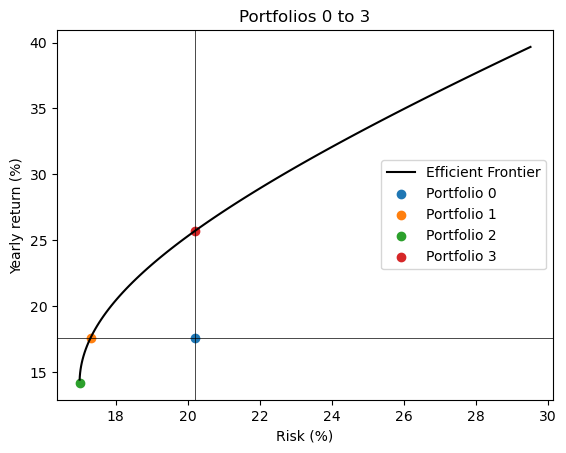

In [97]:
plt.plot(combos_risks, combos_returns, 'black')

plt.scatter(portfolio_0['risk'], portfolio_0['return'])
plt.scatter(portfolio_1['risk'], portfolio_1['return'])
plt.scatter(portfolio_2['risk'], portfolio_2['return'])
plt.scatter(portfolio_3['risk'], portfolio_3['return'])

plt.legend(["Efficient Frontier",
            "Portfolio 0" , "Portfolio 1", "Portfolio 2", "Portfolio 3"
           ], loc = "best")

plt.axhline(portfolio_0['return'], color='black', linewidth=.5)
plt.axvline(portfolio_0['risk'], color='black', linewidth=.5)

plt.title('Portfolios 0 to 3')
plt.ylabel('Yearly return (%)')
plt.xlabel('Risk (%)')

## 5. Porfolio 4: Market Portfolio

As we have learned, every portfolio has a combination of weights that generate some level of risk for a desired return. In the Efficient Frontier the risk is minimized for any desired return, but there exists a porfolio in the Efficient Frontier that yields the most return for every unit of risk taken. This is called the Market Partfolio and it has the highest Sharpe Ratio.





$$
\begin{split}
    Sharpe Ratio = 
    \frac {R_p - R_f}
          {\sigma_p}
\end{split}
$$

Where:
- R<sub>p</sub>: Portfolio expected return
- &sigma;:<sub>p</sub>: Portfolio risk
- R<sub>f</sub>: Risk-free rate of return. A rate that can be earned without risk. Usually short-term bonds issued by developed nations' treasuries. Developed nations are not expected to collapse short-term, so these bonds are considered risk "free".

### 5.1. Risk-free rate historical information

In [39]:
risk_free_asset = "^IRX" # 3-month T-bill
risk_free_data_backup = yf.download(risk_free_asset, period=period, interval=interval)["Adj Close"]

[*********************100%***********************]  1 of 1 completed


In [40]:
expected_risk_free_return = (risk_free_data_backup).mean()
expected_risk_free_return # this is a YEARLY rate of return

1.5237108819475922

### 5.2. Finding the Market Portfolio

Market portfolio's weights:

<!-- Source -->
<!--
https://www.chegg.com/homework-help/questions-and-answers/6-market-portfolio-weights-order-derive-formula-310-ob-serve-slope-capital-market-line-con-q58724372
-->
$$
\begin{split}
    w_M = 
    \frac {V^{-1}{(\mu - R_f\mathbf 1})}
          {\mathbf{1^{'}}V^{-1}{(\mu - R_f\mathbf 1})}
\end{split}
$$

In [41]:
def make_market_portfolio():
    '''
    Makes a portfolio with the higher Sharpe Ratio
    
    Returns:
    + sharpe_portfolio: dictionary
        a portfolio with the maximum Sharpe Ratio
    '''
    v = variance_covariance_matrix
    v_inv = np.linalg.inv(v)

    mu = assets_expected_returns - expected_risk_free_return
    ones_vector = np.array(np.ones(n))

    numerator = np.dot(mu, v_inv)
    denominator = np.dot(np.dot(ones_vector, v_inv), mu)

    market_portfolio_weights = numerator / denominator
    
    market_portfolio = make_portfolio(market_portfolio_weights)
    
    return market_portfolio

In [42]:
portfolio_4 = make_market_portfolio()
print('Portfolio 4')
print_portfolio(portfolio_4)

Portfolio 4
Risk:	29.513212521976634
Return:	39.66600151493942


,XOM,SHW,UPS,ED,JNJ,JPM,MCD,PG,MSFT,GOOG,SPG
Weight,0.295491,0.032526,-0.069992,-0.152543,-0.409079,-0.178197,0.324887,0.720001,0.894049,-0.286423,-0.170718


Text(0.5, 0, 'Risk (%)')

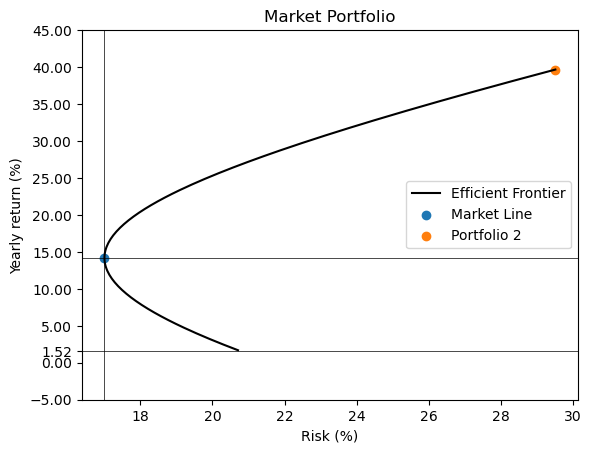

In [43]:
combos_weights, combos_risks, combos_returns = combine_portfolios_2(portfolio_2, portfolio_4, 0, 1.5, 0.01)

mkt_risks = np.array([0, combos_risks[0]])

plt.plot(combos_risks, combos_returns, 'black') # efficient frontier

plt.scatter(portfolio_2['risk'], portfolio_2['return'])
plt.scatter(portfolio_4['risk'], portfolio_4['return'])

plt.legend(["Efficient Frontier",
            "Market Line",
            "Portfolio 2", "Portfolio 4"
           ], loc = "best")

plt.axhline(portfolio_2['return'], color='black', linewidth=.5)

plt.axvline(portfolio_2['risk'], color='black', linewidth=.5)
plt.axhline(expected_risk_free_return, color='black', linewidth=.5)

plt.yticks(list(plt.yticks()[0]) + [expected_risk_free_return])

plt.title('Market Portfolio')
plt.ylabel('Yearly return (%)')
plt.xlabel('Risk (%)')

### 5.3. Capital Allocation Line

The Capital Allocation Line (CAL) or Market Line is tangential to the Efficient Frontier on the Market Portfolio. It can be thought of as the different ways in which capital can be split between the Risk-free asset and the Market Portfolio (where it will be sub-divided between the porfolio's assets).

For a 2-asset portfolio, the variance is calculated as:

$$
\begin{split}
\sigma^2_{p} = 
    w^2_1\sigma^2_1
    + w^2_2\sigma^2_2
    + 2 w_1 w_2 \sigma_{1, 2}
\end{split}
$$

The risk-free rate is considered to be constant, so it's variance and covariance are 0

$$
\begin{split}
\sigma^2_{p} = 
    w^2_1\sigma^2_1
\end{split}
$$

$$
\begin{split}
\sigma_{p} = 
    w_1\sigma_1
\end{split}
$$

Where:
- &sigma;<sub>p</sub>: Total risk of the combination of the Market portfolio and the risk-free asset
- w<sub>1</sub>: Capital allocated to the Market portfolio
- &sigma;<sub>1</sub>: Risk of the market portfolio

For a 2-asset portfolio, the variance is calculated as:

$$
r_p = w_1 r_1 + w_2 r_2
$$
$$
w_1 + w_2 = 1
$$

Where:
- r<sub>p</sub>: Total return of the combination of the Market portfolio and the risk-free asset
- w<sub>1</sub>: Capital allocated to the Market portfolio
- w<sub>2</sub>: Capital allocated to the risk-free asset
- r<sub>1</sub>: Expected return of the market portfolio
- r<sub>2</sub>: Expected return of the risk-free asset

In [44]:
def get_cal_slope(market_portfolio):
    delta_y = market_portfolio['return'] - expected_risk_free_return
    delta_x = market_portfolio['risk'] - 0
    
    cal_slope = delta_y / delta_x
    return cal_slope

Text(0.5, 0, 'Risk (%)')

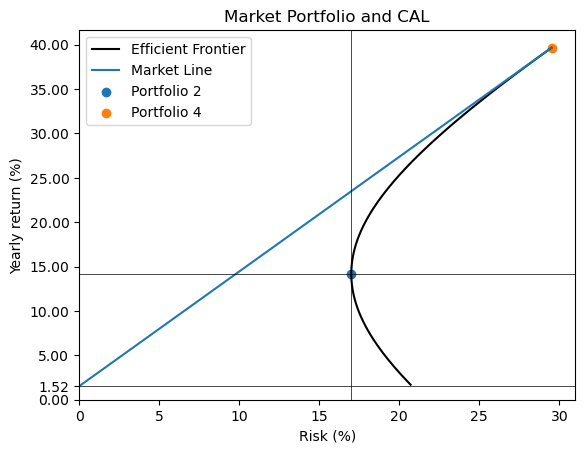

In [45]:
combos_weights, combos_risks, combos_returns = combine_portfolios_2(portfolio_2, portfolio_4, 0, 1.5, 0.01)

mkt_risks = np.array([0, combos_risks[0]])
mkt_returns = expected_risk_free_return + mkt_risks * get_cal_slope(portfolio_4)

plt.plot(combos_risks, combos_returns, 'black') # efficient frontier
plt.plot(mkt_risks, mkt_returns) # market line

plt.scatter(portfolio_2['risk'], portfolio_2['return'])
plt.scatter(portfolio_4['risk'], portfolio_4['return'])

plt.legend(["Efficient Frontier",
            "Market Line",
            "Portfolio 2", "Portfolio 4"
           ], loc = "best")

plt.axhline(portfolio_2['return'], color='black', linewidth=.5)

plt.axvline(portfolio_2['risk'], color='black', linewidth=.5)
plt.axhline(expected_risk_free_return, color='black', linewidth=.5)

plt.yticks(list(plt.yticks()[0]) + [expected_risk_free_return])
plt.axis([0, 1.05 * portfolio_4['risk'], 0, 1.05 * portfolio_4['return']])

plt.title('Market Portfolio and CAL')
plt.ylabel('Yearly return (%)')
plt.xlabel('Risk (%)')

The benefits of this further diversification are greater risk minimization or return maximization. For example, it is possible to find a distribution of capital that has less risk than the minimum-variance portfolio, but keeps its return.

It also solves the problem of investors incurring in more risk if they targeted a return lower than the minimum-variance portfolio's return. 

### 5.4. Distributing capital between the Market portfolio and the risk-free asset to maximize return

$$
\begin{split}
\sigma_{p} = 
    w_1\sigma_1
\end{split}
$$
$$
\begin{split}
w_1 = \sigma_1 / \sigma_{p}
\end{split}
$$

In [46]:
def cal_return_optimize(risk, market_portfolio):
    w_1 = risk / market_portfolio['risk'] # weight for the market_portfolio
    w_2 = (1 - w_1) # weight for the risk-free asset
    
    combo_return = w_1 * market_portfolio['return'] + w_2 * expected_risk_free_return
    #combo_risk = w_1 * market_portfolio['risk']
    
    print(f"With the following capital allocations:")
    print(f"Market portfolio:\t{round(w_1, 4)*100} %")
    print(f"Risk-free asset:\t{round(w_2, 4)*100} %")
    print(f"Risk is kept at:\t{round(risk, 2)} %")
    print(f"New return:\t\t{round(combo_return, 2)} %")
    
    return risk, combo_return

In [47]:
cal_return_optimization_risk,  cal_return_optimization_return = cal_return_optimize(portfolio_2['risk'], portfolio_4)

With the following capital allocations:
Market portfolio:	57.60999999999999 %
Risk-free asset:	42.39 %
Risk is kept at:	17.0 %
New return:		23.5 %


### 5.5. Distributing capital between the Market portfolio and the risk-free asset to minimize risk

$$
r_p = w_1 r_1 + w_2 r_2
$$
$$
w_1 + w_2 = 1
$$
$$
w_1 = \frac{r_p - r_2}{r_1 - r_2}
$$

In [48]:
def cal_risk_optimize(target_return, market_portfolio):
    w_1 = (target_return - expected_risk_free_return) / (market_portfolio['return'] - expected_risk_free_return)  # weight for the market_portfolio
    w_2 = (1 - w_1) # weight for the risk-free asset
    
    combo_return = w_1 * market_portfolio['return'] + w_2 * expected_risk_free_return
    combo_risk = w_1 * market_portfolio['risk']
    
    print(f"With the following capital allocations:")
    print(f"Market portfolio:\t{round(w_1, 4)*100} %")
    print(f"Risk-free asset:\t{round(w_2, 4)*100} %")
    print(f"New risk:\t\t{round(combo_risk, 2)} %")
    print(f"Return stays at:\t{round(target_return, 2)} %")
    return combo_risk, combo_return

In [49]:
cal_risk_optimization_risk, cal_risk_optimization_return = cal_risk_optimize(portfolio_2['return'], portfolio_4)

With the following capital allocations:
Market portfolio:	33.19 %
Risk-free asset:	66.81 %
New risk:		9.8 %
Return stays at:	14.18 %


Text(0.5, 0, 'Risk (%)')

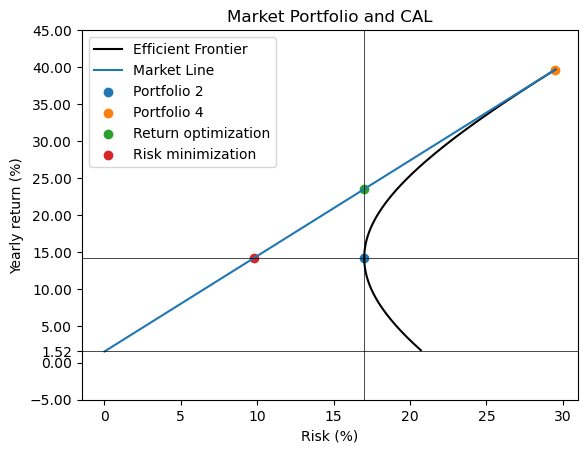

In [51]:
combos_weights, combos_risks, combos_returns = combine_portfolios_2(portfolio_2, portfolio_4, 0, 1.5, 0.01)

mkt_risks = np.array([0, combos_risks[0]])
mkt_returns = expected_risk_free_return + mkt_risks * get_cal_slope(portfolio_4)

plt.plot(combos_risks, combos_returns, 'black') # efficient frontier
plt.plot(mkt_risks, mkt_returns) # market line

plt.scatter(portfolio_2['risk'], portfolio_2['return'])
plt.scatter(portfolio_4['risk'], portfolio_4['return'])
plt.scatter(cal_return_optimization_risk, cal_return_optimization_return)
plt.scatter(cal_risk_optimization_risk, cal_risk_optimization_return)

plt.legend(["Efficient Frontier",
            "Market Line",
            "Portfolio 2", "Portfolio 4",
            "Return optimization", "Risk minimization"
           ], loc = "best")

plt.axhline(portfolio_2['return'], color='black', linewidth=.5)

plt.axvline(portfolio_2['risk'], color='black', linewidth=.5)
plt.axhline(expected_risk_free_return, color='black', linewidth=.5)

plt.yticks(list(plt.yticks()[0]) + [expected_risk_free_return])
#plt.axis([0, 1.05 * portfolio_4['risk'], 0, 1.05 * portfolio_4['return']])

plt.title('Market Portfolio and CAL')
plt.ylabel('Yearly return (%)')
plt.xlabel('Risk (%)')

## 6. Approximating the Efficient Frontier with Monte Carlo simulation

In [52]:
random_risks = []
random_returns = []

for i in range(10_000):    
    portfolio = make_random_portfolio()
    risk = portfolio['risk']
    portfolio_return = portfolio['return']
    
    random_risks.append(risk)
    random_returns.append(portfolio_return)

Text(0.5, 0, 'Risk (%)')

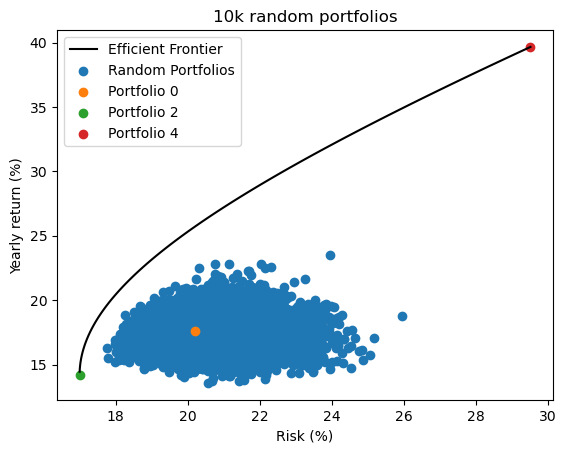

In [53]:
combos_weights, combos_risks, combos_returns = combine_portfolios_2(portfolio_2, portfolio_4, 0, 1, 0.01)

plt.plot(combos_risks, combos_returns, 'black')
plt.scatter(random_risks, random_returns)
plt.scatter(portfolio_0['risk'], portfolio_0['return'])
plt.scatter(portfolio_2['risk'], portfolio_2['return'])
plt.scatter(portfolio_4['risk'], portfolio_4['return'])

plt.legend(["Efficient Frontier",
            "Random Portfolios",
            "Portfolio 0" , "Portfolio 2", "Portfolio 4"],
           loc = "upper left")

plt.title('10k random portfolios')
plt.ylabel('Yearly return (%)')
plt.xlabel('Risk (%)')

As we can see in the graph above, 10'000 random portfolios don't approximate the Efficient Frontier very well, in fact we can observe a big gap between the Efficient Frontier and the random portfolios.

One of the reasons for this is because the portfolios in the Efficient Frontier allow for negative weights (i.e. shorting), while the random portfolios only have positive weights.

In [54]:
def get_random_positive_negative_weights():
    ''' 
    Creates random positive weights for each asset. Weights add-up to 1 (100%)
        
    Returns:
    + weights: numpy array
        n random weights that add up to 1
    '''
    weights = np.random.random_sample(size = n) # sum != 1
    weights = (weights * 2) - 1 # from -1 to 1
    weights = weights / weights.sum() # sum = 1
   
    return weights

In [55]:
positive_negative_random_risks = []
positive_negative_random_returns = []

for i in range(10_000):    
    portfolio = make_portfolio(get_random_positive_negative_weights())
    risk = portfolio['risk']
    portfolio_return = portfolio['return']
    
    positive_negative_random_risks.append(risk)
    positive_negative_random_returns.append(portfolio_return)

Text(0.5, 0, 'Risk (%)')

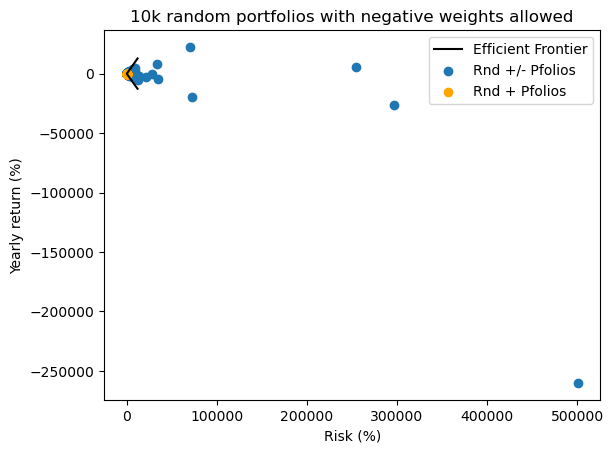

In [56]:
combos_weights, combos_risks, combos_returns = combine_portfolios_2(portfolio_2, portfolio_4, -500, 500, 0.2)

# frontier
plt.plot(combos_risks, combos_returns, 'black') 

# portfolios
plt.scatter(positive_negative_random_risks, positive_negative_random_returns) # +/- random
plt.scatter(random_risks, random_returns, c='orange') # + random

plt.legend(["Efficient Frontier",
            "Rnd +/- Pfolios", "Rnd + Pfolios"],
           loc = "best")

plt.title('10k random portfolios with negative weights allowed')
plt.ylabel('Yearly return (%)')
plt.xlabel('Risk (%)')

Even with the restriction that weights must add-up to 1, random weights can generate very extreme portfolios. Let's zoom in.

Text(0.5, 0, 'Risk (%)')

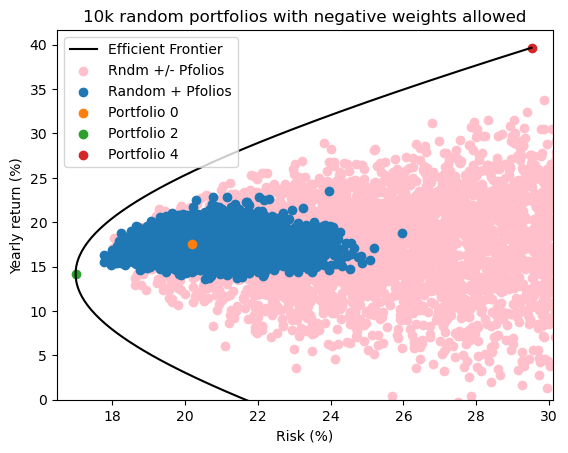

In [57]:
combos_weights, combos_risks, combos_returns = combine_portfolios_2(portfolio_2, portfolio_4, 0, 2, 0.01)

plt.plot(combos_risks, combos_returns, 'black')
plt.scatter(positive_negative_random_risks, positive_negative_random_returns, c='pink')
plt.scatter(random_risks, random_returns)
plt.scatter(portfolio_0['risk'], portfolio_0['return'])
plt.scatter(portfolio_2['risk'], portfolio_2['return'])
plt.scatter(portfolio_4['risk'], portfolio_4['return'])

plt.legend(["Efficient Frontier",
            "Rndm +/- Pfolios", "Random + Pfolios",
            "Portfolio 0" , "Portfolio 2", "Portfolio 4"],
           loc = "best")

plt.axis([0.97 * portfolio_2['risk'], 1.02 * portfolio_4['risk'],
          0, 1.05 * portfolio_4['return']])

plt.title('10k random portfolios with negative weights allowed')
plt.ylabel('Yearly return (%)')
plt.xlabel('Risk (%)')

With random weights allowed, we can see some points getting closer to the Efficient Frontier.

## 7. Non-shorting portfolios

It is not possible to find the non-shorting global-minimum-variance portfolio analytically, instead it has to be done numerically (by making guesses) using optimization algorithms (see https://bookdown.org/compfinezbook/introFinRbook/Portfolio-Theory-No-Shorts.html 13.3.2 remark 1). For that we will use scipy.optimize

In [58]:
import scipy.optimize as sci_opt

### 7.1. Portfolio 5: Highest return-risk ratio non-shorting portfolio

In [59]:
# Adapted from https://github.com/areed1192/portfolio-optimization/blob/master/samples/portfolio_optimization.ipynb

def check_weights(weights):
    '''
    Adds a set of weights then, to be used by sci_opt, substracts one.
    
    Returns:
        0: The weights do add-up to one
    not 0: The weights do not add-up to one
    '''
    return weights.sum() - 1

In [60]:
def get_negative_return_risk_ratio(weights):
    '''
    Calculates the return-risk ratio from a given set of weights
    Then, to be used by sci_opt, the value is multiplied by -1
    
    Returns:
        The negative return-risk ratio
    '''
    portfolio_return = get_portfolio_return(weights)
    portfolio_risk = get_portfolio_risk(weights)
    return_risk_ratio = portfolio_return / portfolio_risk
    
    return return_risk_ratio * (-1)

In [61]:
# The initial guess weights can be even weights, random weights, or subjective weights.
initial_guess = get_even_weights()

# Considerations for the following guesses:
# -------------------------
# Each asset can have a weight between 0-1 (0%-100%)
bounds = tuple((0, 1) for ticker in range(n))

# Weights have to add-up to 100%
constraints = ({'type': 'eq', # the function passed below has to *equal* 0
                'fun': check_weights})

In [62]:
# Find weights for the non-shorting portfolio with the maximum risk-return ratio
no_shorts_max_return_risk_ratio_report = sci_opt.minimize(
                                            get_negative_return_risk_ratio, # minimizing the *negative* r-r ratio
                                                                            # is like maximizing the r-r ratio
                                            initial_guess,
                                            method='SLSQP',
                                            bounds=bounds,
                                            constraints=constraints
                                            )

In [63]:
no_shorts_max_return_risk_ratio_weights = no_shorts_max_return_risk_ratio_report.x

In [64]:
portfolio_5 = make_portfolio(no_shorts_max_return_risk_ratio_weights)
print('Portfolio 5')
print_portfolio(portfolio_5)

Portfolio 5
Risk:	21.68581608069912
Return:	26.43640780983482


,XOM,SHW,UPS,ED,JNJ,JPM,MCD,PG,MSFT,GOOG,SPG
Weight,0.053679,0.0,0.0,0.0,6.247715e-17,3.174002e-17,0.091067,0.399729,0.455525,0.0,4.133521e-18


No negative weights.

### 7.2. Portfolio 6: Minimum-risk non-shorting portfolio

In [65]:
# Find weights for the minimum risk
no_shorts_min_risk_report = sci_opt.minimize(
                                get_portfolio_risk, #minimize this
                                initial_guess,
                                method='SLSQP',
                                bounds=bounds,
                                constraints=constraints
                            )

In [66]:
no_shorts_min_risk_weights = no_shorts_min_risk_report.x

In [67]:
portfolio_6 = make_portfolio(no_shorts_min_risk_weights)
print("Portfolio 6")
print_portfolio(portfolio_6)

Portfolio 6
Risk:	17.188010621100318
Return:	15.01766541932947


,XOM,SHW,UPS,ED,JNJ,JPM,MCD,PG,MSFT,GOOG,SPG
Weight,0.055234,1.896270e-16,0.063343,0.135667,0.334642,8.447351e-16,0.196277,0.172035,1.116212e-15,0.042802,0.0


No negative weights

Text(0.5, 0, 'Risk (%)')

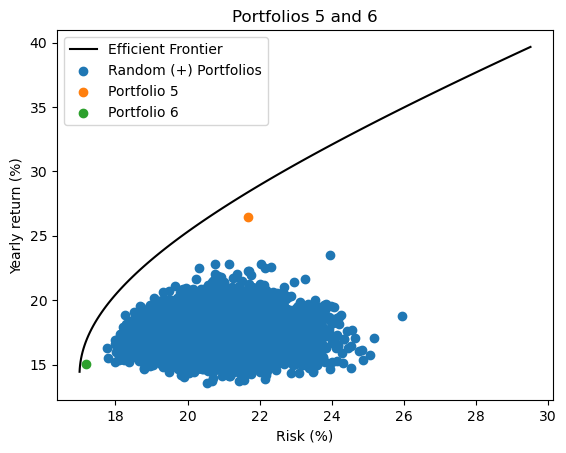

In [93]:
combos_weights, combos_risks, combos_returns = combine_portfolios_2(portfolio_2, portfolio_4, 0, 1, 0.01)

plt.plot(combos_risks, combos_returns, 'black')
plt.scatter(random_risks, random_returns)
#plt.scatter(portfolio_2['risk'], portfolio_2['return'])
#plt.scatter(portfolio_4['risk'], portfolio_4['return'])
plt.scatter(portfolio_5['risk'], portfolio_5['return'])
plt.scatter(portfolio_6['risk'], portfolio_6['return'])

plt.legend(["Efficient Frontier", "Random (+) Portfolios",
#            "Portfolio 2", "Portfolio 4",
           "Portfolio 5", "Portfolio 6"],
           loc = "upper left")

plt.title('Portfolios 5 and 6')
plt.ylabel('Yearly return (%)')
plt.xlabel('Risk (%)')

### 7.3. Drawing a frontier with Portfolios 5 and 6

In [94]:
five_six_frontier_weights, five_six_frontier_risks, five_six_frontier_returns = combine_portfolios_2(portfolio_5, portfolio_6, 0, 1, 0.01)

Text(0.5, 0, 'Risk (%)')

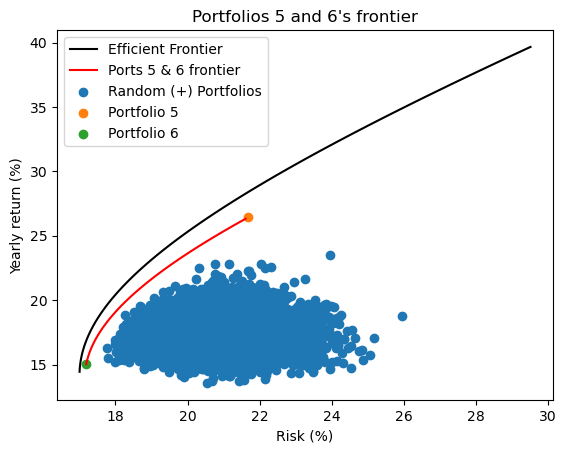

In [95]:
# Frontiers
plt.plot(combos_risks, combos_returns, 'black')
plt.plot(five_six_frontier_risks, five_six_frontier_returns, 'red')

# Points
plt.scatter(random_risks, random_returns)
plt.scatter(portfolio_5['risk'], portfolio_5['return'])
plt.scatter(portfolio_6['risk'], portfolio_6['return'])

# Legend
plt.legend(["Efficient Frontier", "Ports 5 & 6 frontier",
            "Random (+) Portfolios",
           "Portfolio 5", "Portfolio 6"],
           loc = "upper left")

plt.title("Portfolios 5 and 6's frontier")
plt.ylabel('Yearly return (%)')
plt.xlabel('Risk (%)')

### Is this a valid non-shorting frontier?

In [71]:
# Check all weights of all combinations created to make the frontier
# If a negative weight is found, then this is not a valid non-shorting frontier

for weights_set in five_six_frontier_weights:
    for weight in weights_set:
        if weight < 0:
            print('Negative weight found!')
            break
    else:
        continue  # only executed if the inner loop did NOT break
    break
else:
    print('No negative weights found')

No negative weights found


No negative weights were found, which makes sense since neither portfolio is given a negative proportion at any moment, and they both only have positive weights-sets. But if we go beyond either portfolio, we can generate negative weights.

### 7.4. Numerically finding multiple non-shorting minimum-risk points

In [72]:
# Adapted from https://quantpy.com.au/python-for-finance/portfolio-optimisation/

def optimize_risk(target_return):
    '''
    Numerically finds a porfolio that minimizes risk but keeps a target return
    
    Parameters:
    + target_return: float
        A target return to keep while reducing risk
    
    Returns:
    + risk_optimized_weights: np.array
        weights-set that maintain return but lower risk
    '''
    
    def check_return(weights):
        '''
        Subtracts the return generated by a weights-set from
        the target_return (target_return is one level up)
        
        Parameters:
        + weights: np.array
            The weights-set to calculate the portfolio return from
        
        Returns (for optimization purposes):
            0: The returns are equal
        not 0: The returns are not equal
        '''
        guess_return = get_portfolio_return(weights)     
        return guess_return - target_return
    
    initial_guess = get_even_weights()
    bounds = tuple((0, 1) for ticker in range(n)) # weights between 0 and 1
    
    # constraints
    constraint_1 = {'type': 'eq', # sum_weights(w) has to equal 0
                    'fun': check_weights
                   }
    constraint_2 = {'type': 'eq', # check_return(w) has to equal 0
                    'fun': check_return
                    #'fun': lambda w: portfolioReturn(w) - target_return
                   }
    constraints = ([constraint_1, constraint_2])
    
    # run optimizer
    optimizer_report = sci_opt.minimize(
                            get_portfolio_risk,
                            initial_guess,
                            method='SLSQP',
                            bounds=bounds,
                            constraints=constraints
                        )

    risk_optimized_weights = optimizer_report.x
    
    return risk_optimized_weights

In [73]:
target_returns = np.linspace(portfolio_6['return'], portfolio_5['return'], 200)

optm_risks = []
optm_returns = []
optm_weights = []

for target_return in target_returns:
    risk_optimized_weights = optimize_risk(target_return)
    
    portfolio_return = get_portfolio_return(risk_optimized_weights)
    risk = get_portfolio_risk(risk_optimized_weights)
    
    optm_weights.append(risk_optimized_weights)
    optm_risks.append(risk)
    optm_returns.append(target_return)

Text(0.5, 0, 'Risk (%)')

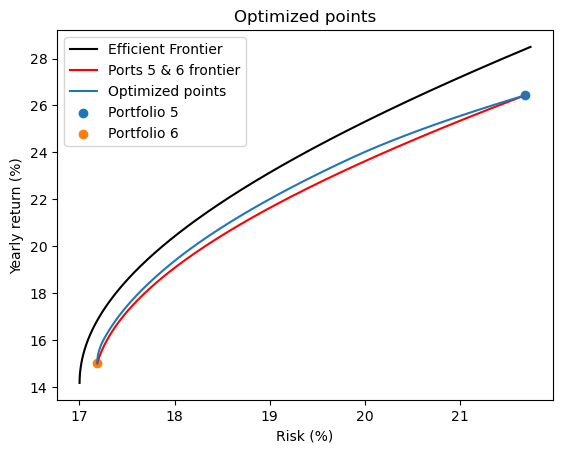

In [85]:
combos_weights, combos_risks, combos_returns = combine_portfolios_2(portfolio_1, portfolio_2, 0, 4.2, 0.01)

# Frontiers
plt.plot(combos_risks, combos_returns, c='black') # efficient frontier
plt.plot(five_six_frontier_risks, five_six_frontier_returns, c='red') # 5&6 frontier

# Points
plt.plot(optm_risks, optm_returns) # numerically optimized min-risk points
plt.scatter(portfolio_5['risk'], portfolio_5['return'])
plt.scatter(portfolio_6['risk'], portfolio_6['return'])

# Legend
plt.legend(["Efficient Frontier", "Ports 5 & 6 frontier",
            "Optimized points",
           "Portfolio 5", "Portfolio 6"],
           loc = "upper left")

plt.title("Optimized points")
plt.ylabel('Yearly return (%)')
plt.xlabel('Risk (%)')

Turns out that the frontier made by combining portfolios 5 and 6 is NOT a true frontier for minimum-risk non-shorting portfolios.

### 7.5. CAL optimization for non-shorting portfolios

A new Market Line can be drawn with Portfolio 5 to see how returns can be optimized by investing in the risk-free asset.

In [76]:
cal_risks = [0, portfolio_5['risk']]
cal_returns = [expected_risk_free_return, portfolio_5['return']]

In [77]:
return_opt_risk, return_opt_return = cal_return_optimize(portfolio_6['risk'], portfolio_5)

With the following capital allocations:
Market portfolio:	79.25999999999999 %
Risk-free asset:	20.74 %
Risk is kept at:	17.19 %
New return:		21.27 %


In [78]:
risk_opt_risk, risk_opt_return = cal_risk_optimize(portfolio_6['return'], portfolio_5)

With the following capital allocations:
Market portfolio:	54.16 %
Risk-free asset:	45.839999999999996 %
New risk:		11.75 %
Return stays at:	15.02 %


Text(0.5, 0, 'Risk (%)')

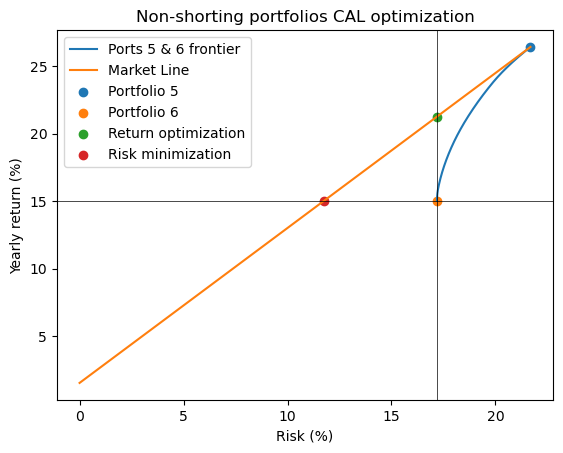

In [96]:
# Frontiers
plt.plot(optm_risks, optm_returns)

# Line
plt.plot(cal_risks, cal_returns)

# Points
plt.scatter(portfolio_5['risk'], portfolio_5['return'])
plt.scatter(portfolio_6['risk'], portfolio_6['return'])
plt.scatter(return_opt_risk, return_opt_return)
plt.scatter(risk_opt_risk, risk_opt_return)

# Legend
plt.legend(["Ports 5 & 6 frontier", "Market Line",
           "Portfolio 5", "Portfolio 6",
           "Return optimization", "Risk minimization"
           ],
           loc = "upper left")

plt.axhline(portfolio_6['return'], color='black', linewidth=.5)
plt.axvline(portfolio_6['risk'], color='black', linewidth=.5)

plt.title("Non-shorting portfolios CAL optimization")
plt.ylabel('Yearly return (%)')
plt.xlabel('Risk (%)')